In [44]:
from data_processing import get_data
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import Input, LSTM, Dense, concatenate
from keras import Model, optimizers, losses, metrics
import matplotlib.pyplot as plt

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [45]:
normal_data, abnormal_data, real_abnormal_data, real_abnormal_data_2 = get_data("rene")

Normal data shape: (45341, 125)
Abnormal data shape: (82, 125)
Real abnormal data shape: (891, 125)
Real abnormal data 2 shape: (891, 125)


In [46]:
# Transform torch tensors to keras tensors
normal_data = tf.convert_to_tensor(normal_data.numpy())
abnormal_data = tf.convert_to_tensor(abnormal_data.numpy())
real_abnormal_data = tf.convert_to_tensor(real_abnormal_data.numpy())
real_abnormal_data_2 = tf.convert_to_tensor(real_abnormal_data_2.numpy())

In [47]:
data = tf.concat([normal_data, abnormal_data, real_abnormal_data, real_abnormal_data_2], 0)
data.shape

TensorShape([47205, 125])

In [48]:
# Create the labels, since we will be doing supervised learning. 1 represents a normal trajectory, 0 is abnormal
labels = np.concatenate([
    np.ones(normal_data.shape[0]),
    np.zeros(abnormal_data.shape[0]),
    np.zeros(real_abnormal_data.shape[0]),
    np.zeros(real_abnormal_data_2.shape[0])
], 0)

labels = np.reshape(labels, [-1, 1])
labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [49]:
# Let's see the distribution of normal and abnormal data
neg, pos = tf.math.bincount(labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Normal: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 47205
    Normal: 45341 (96.05% of total)



In [50]:
data = tf.concat([data, labels], 1)
data.shape

TensorShape([47205, 126])

In [51]:
train_data, test_data = train_test_split(data.numpy(), test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [52]:
train_labels = train_data[:,-1].astype('int32')
train_categories = train_data[:,0].astype('int32')
train_data = train_data[:,1:-1]

val_labels = val_data[:,-1].astype('int32')
val_categories = val_data[:,0].astype('int32')
val_data = val_data[:,1:-1]

test_labels = test_data[:,-1].astype('int32')
test_categories = test_data[:,0].astype('int32')
test_data = test_data[:,1:-1]

In [53]:
print(train_labels.shape)
print(train_categories.shape)
print(train_data.shape)

(30211,)
(30211,)
(30211, 124)


In [54]:
# The category data needs to be one-hot encoded
train_categories = np.reshape(train_categories, newshape=[-1, 1])
val_categories = np.reshape(val_categories, newshape=[-1, 1])
test_categories = np.reshape(test_categories, newshape=[-1, 1])

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(train_categories)
one_hot_encoder.fit(val_categories)
one_hot_encoder.fit(test_categories)

train_categories = one_hot_encoder.transform(train_categories)
val_categories = one_hot_encoder.transform(val_categories)
test_categories = one_hot_encoder.transform(test_categories)

C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [55]:
train_categories.shape

(30211, 2)

In [56]:
# The trajectory data however needs to be reshaped into data containing 31 timesteps for 4 features.
# The trajectory features are the x and y location, and the x and y velocities over 31 timesteps

features = 4
timesteps = int(data.shape[1] / features)

train_data = np.transpose(np.reshape(train_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
val_data = np.transpose(np.reshape(val_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
test_data = np.transpose(np.reshape(test_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])

train_data.shape

(30211, 4, 31)

In [57]:
train_labels.shape

(30211,)

In [58]:
bool_train_labels = train_labels != 0

pos_features = train_data[bool_train_labels]
neg_features = train_data[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

pos_categories = train_categories[bool_train_labels]
neg_categories = train_categories[~bool_train_labels]

In [59]:
ids = np.arange(len(neg_features))
choices = np.random.choice(ids, len(pos_features))

res_neg_features = neg_features[choices]
res_neg_labels = neg_labels[choices]
res_neg_categories = neg_categories[choices]

res_neg_features.shape

(29070, 4, 31)

In [60]:
resampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
resampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)
resampled_categories = np.concatenate([res_neg_categories, pos_categories], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]
resampled_categories = resampled_categories[order]

print(resampled_features.shape)
print(resampled_labels.shape)
print(resampled_categories.shape)

(58140, 4, 31)
(58140,)
(58140, 2)


In [61]:
BATCH_SIZE=128

resampled_steps_per_epoch = np.ceil(2.0*pos.numpy()/BATCH_SIZE)
resampled_steps_per_epoch

709.0

In [62]:
# Now to define the network

# Trajectory data
trajectory_input_shape = resampled_features.shape[1:]
units = 100
trajectory_input = Input(shape=trajectory_input_shape)
trajectory_output = LSTM(units)(trajectory_input)

# Category data
category_input = Input(shape=resampled_categories.shape[1:])

# Merge and add dense layer
merge_layer = concatenate([category_input, trajectory_output])
main_output = Dense(units=1,activation="sigmoid")(merge_layer)

# Define the model with two inputs
model = Model(inputs=[trajectory_input, category_input], outputs=[main_output])

In [63]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy')
]

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [64]:
EPOCHS = 10

resampled_history = model.fit(
    [resampled_features, resampled_categories],
    resampled_labels,
    # These are not real epochs
    steps_per_epoch=resampled_steps_per_epoch,
    epochs=EPOCHS,
    validation_data=([val_data, val_categories], val_labels))

Epoch 1/10
709/709 [==============================] - 9s 10ms/step - loss: 0.1140 - tp: 27597.0000 - fp: 646.0000 - tn: 28743.0000 - fn: 1818.0000 - accuracy: 0.9581 - val_loss: 0.0525 - val_tp: 7151.0000 - val_fp: 1.0000 - val_tn: 309.0000 - val_fn: 92.0000 - val_accuracy: 0.9877
Epoch 2/10
709/709 [==============================] - 6s 9ms/step - loss: 0.0139 - tp: 29244.0000 - fp: 36.0000 - tn: 29380.0000 - fn: 144.0000 - accuracy: 0.9969 - val_loss: 0.0032 - val_tp: 7243.0000 - val_fp: 0.0000e+00 - val_tn: 310.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
709/709 [==============================] - 6s 9ms/step - loss: 0.0019 - tp: 29410.0000 - fp: 1.0000 - tn: 29392.0000 - fn: 1.0000 - accuracy: 1.0000 - val_loss: 5.0427e-04 - val_tp: 7243.0000 - val_fp: 0.0000e+00 - val_tn: 310.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
709/709 [==============================] - 6s 9ms/step - loss: 5.8884e-04 - tp: 29411.0000 - fp: 0.0000e+00 - tn: 29393.0000 - fn: 0.0

In [65]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

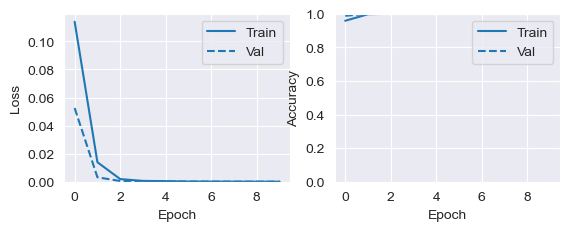

In [66]:
plot_metrics(resampled_history)

In [67]:
resampled_results = model.evaluate([test_data, test_categories], test_labels, batch_size=BATCH_SIZE, verbose=0)

In [68]:
for name, value in zip(model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

loss :  2.4158693122444674e-05
tp :  9028.0
fp :  0.0
tn :  413.0
fn :  0.0
accuracy :  1.0



In [69]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [70]:
test_predictions = model.predict([test_data, test_categories], batch_size=BATCH_SIZE)

74/74 [==============================] - 0s 2ms/step


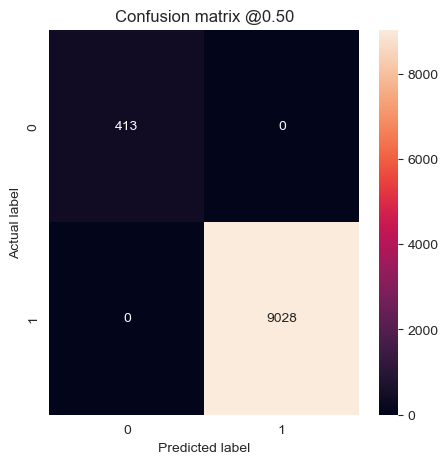

In [71]:
plot_cm(test_labels, test_predictions)